In [3]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "/Users/michal/export/0221_tpu_00/1550749880/"
predict_fn = predictor.from_saved_model(export_dir)



INFO:tensorflow:Restoring parameters from /Users/michal/export/0221_tpu_00/1550749880/variables/variables


In [4]:
from matplotlib import pyplot as plt
import numpy as np

In [6]:
import sys 
sys.path.insert(0,'..')

In [8]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [9]:
np.set_printoptions(precision=2, suppress=True)

In [11]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
# META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-30-lev-30/model.ckpt-3062.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


# sess=tf.Session()    
#First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
# sess.run(tf.global_variables_initializer())
# saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

# graph = tf.get_default_graph()

In [7]:
#g_inputs = graph.get_tensor_by_name("inputs:0")

In [8]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [9]:
# LEVEL = 30

In [10]:
# g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
# g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [12]:
np.set_printoptions(precision=3, suppress=True)

In [12]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [13]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        # policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [19]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [20]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [21]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [22]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    if light == False:
        compute_and_print_steps(sats, RandomVarDPLL)
        compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    if light == False:
        compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

 30%|███       | 3/10 [00:00<00:00, 22.27it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


#Sats: 10; avg step: 912.40; stdev step: 681.64; avg error: 6.40; stdev error: 2.37


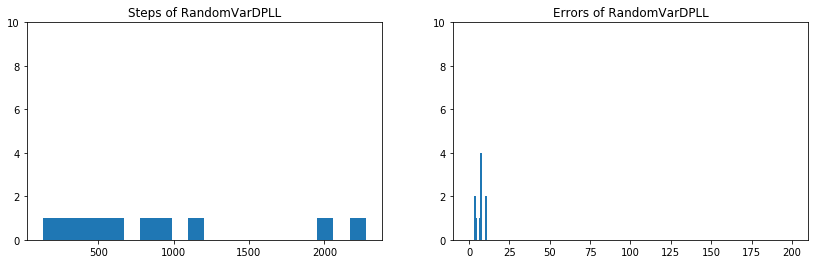

100%|██████████| 10/10 [00:00<00:00, 21.64it/s]


#Sats: 10; avg step: 561.70; stdev step: 388.96; avg error: 4.60; stdev error: 1.69


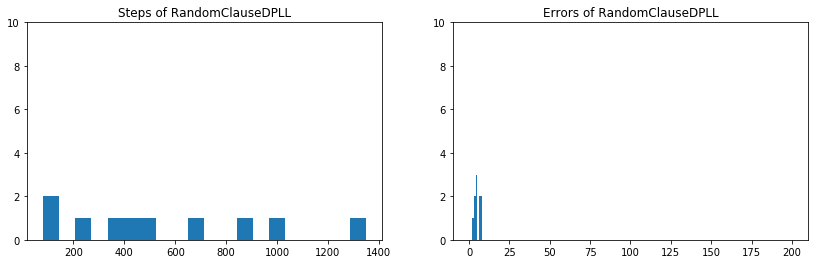

100%|██████████| 10/10 [00:22<00:00,  2.08s/it]


#Sats: 10; avg step: 298.50; stdev step: 399.24; avg error: 1.50; stdev error: 1.02


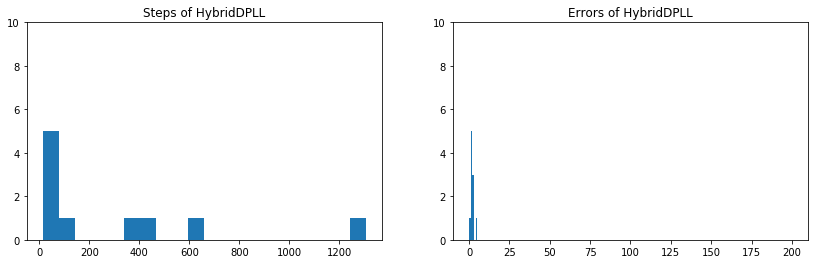

100%|██████████| 10/10 [01:17<00:00,  9.33s/it]


#Sats: 10; avg step: 465.00; stdev step: 576.90; avg error: 1.50; stdev error: 0.92


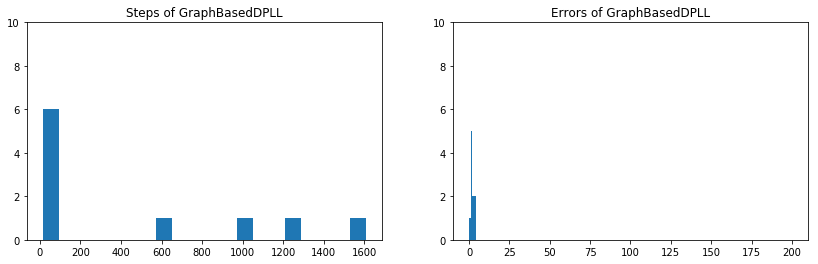

100%|██████████| 10/10 [00:00<00:00, 36.07it/s]


#Sats: 10; avg step: 241.00; stdev step: 293.14; avg error: 2.20; stdev error: 1.40


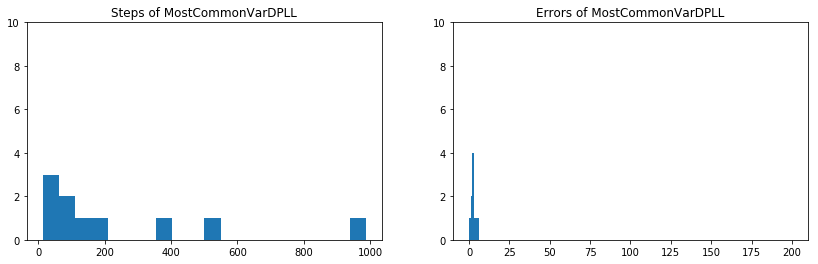

In [23]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 204.72it/s]

We have generated 10 formulas
#Sats: 10; avg step: 65.40; stdev step: 30.74; avg error: 3.80; stdev error: 1.47


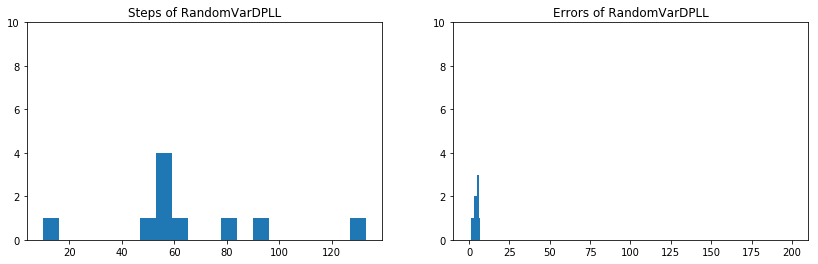

100%|██████████| 10/10 [00:00<00:00, 168.35it/s]


#Sats: 10; avg step: 61.70; stdev step: 35.19; avg error: 2.50; stdev error: 1.36


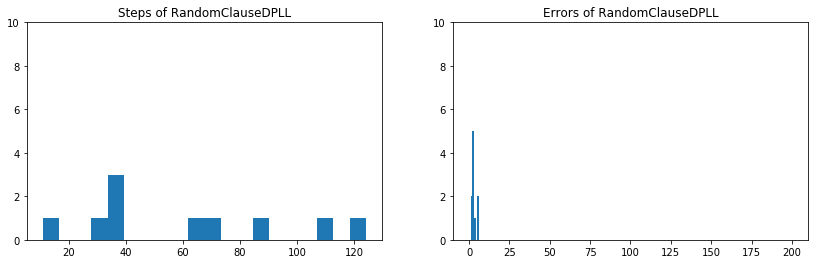

100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


#Sats: 10; avg step: 39.80; stdev step: 28.47; avg error: 0.80; stdev error: 0.60


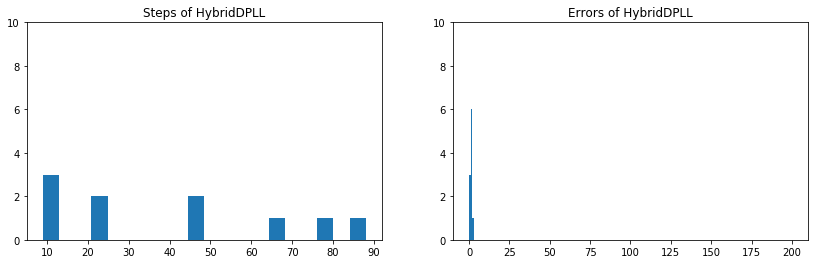

100%|██████████| 10/10 [00:08<00:00,  1.42it/s]


#Sats: 10; avg step: 39.80; stdev step: 28.47; avg error: 0.80; stdev error: 0.60


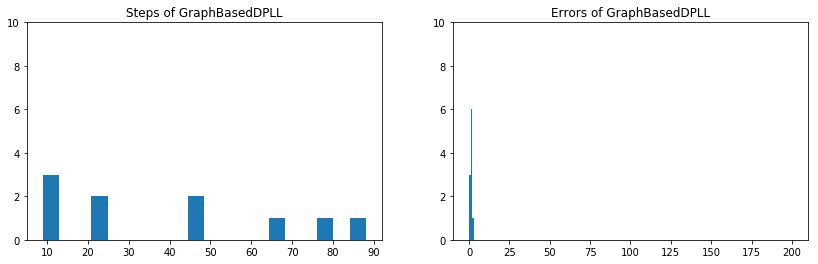

100%|██████████| 10/10 [00:00<00:00, 237.60it/s]


#Sats: 10; avg step: 25.60; stdev step: 19.78; avg error: 1.20; stdev error: 0.60


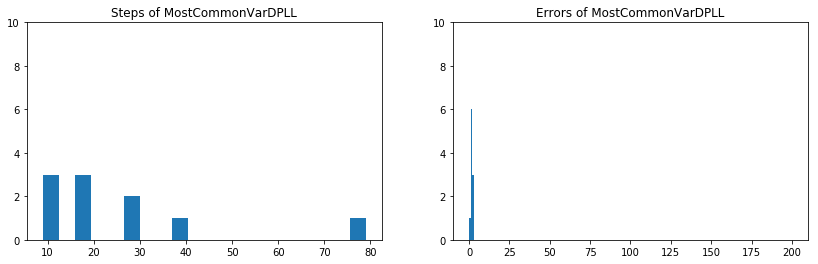

In [24]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 155.64it/s]

We have generated 10 formulas
#Sats: 10; avg step: 91.90; stdev step: 48.24; avg error: 4.50; stdev error: 1.63


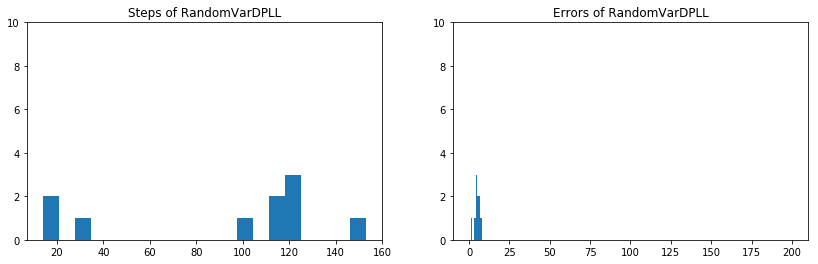

100%|██████████| 10/10 [00:00<00:00, 76.16it/s]


#Sats: 10; avg step: 74.80; stdev step: 65.20; avg error: 2.40; stdev error: 1.80


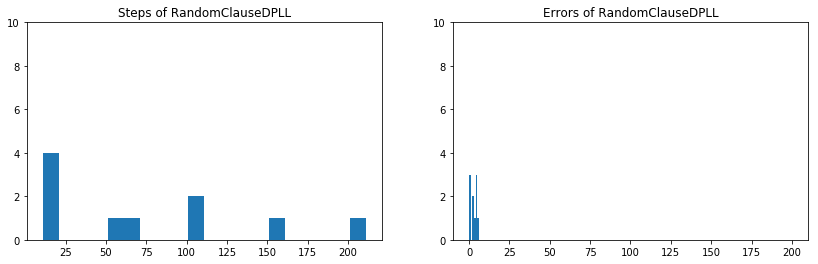

100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


#Sats: 10; avg step: 27.10; stdev step: 22.00; avg error: 0.70; stdev error: 0.90


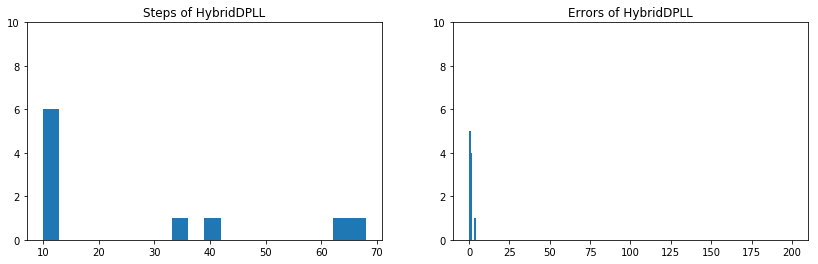

100%|██████████| 10/10 [00:06<00:00,  1.88it/s]


#Sats: 10; avg step: 27.10; stdev step: 22.00; avg error: 0.70; stdev error: 0.90


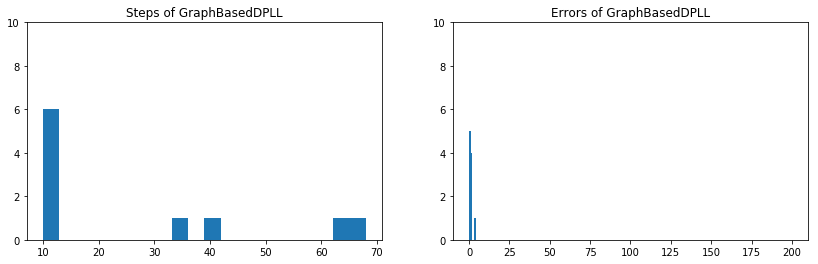

100%|██████████| 10/10 [00:00<00:00, 130.25it/s]


#Sats: 10; avg step: 51.80; stdev step: 36.34; avg error: 1.30; stdev error: 0.78


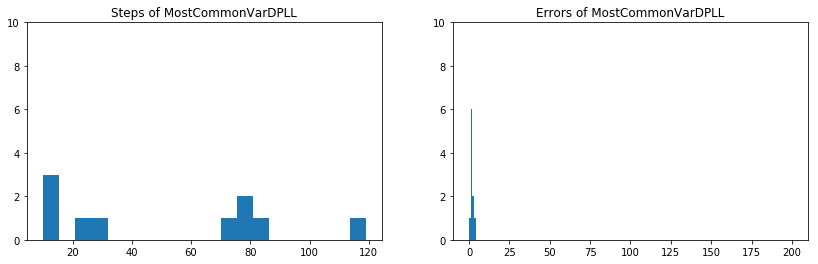

In [25]:
print_all(10, 200, 10)

 60%|██████    | 6/10 [00:00<00:00, 38.35it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 35.22it/s]


#Sats: 10; avg step: 265.70; stdev step: 187.47; avg error: 5.20; stdev error: 1.47


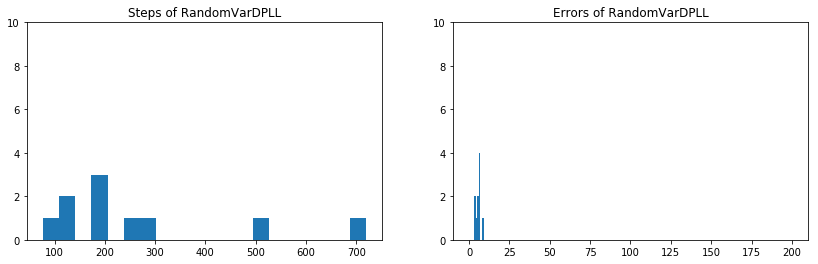

100%|██████████| 10/10 [00:00<00:00, 41.96it/s]


#Sats: 10; avg step: 191.80; stdev step: 100.01; avg error: 3.60; stdev error: 1.50


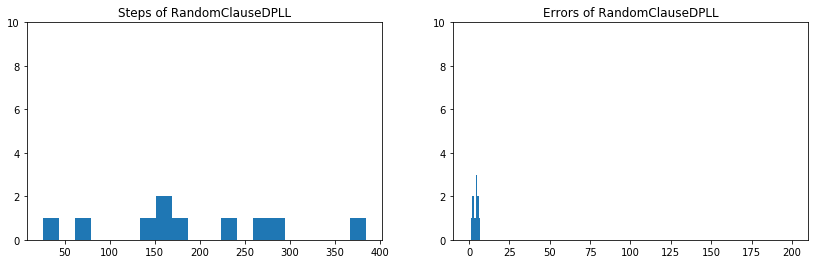

100%|██████████| 10/10 [00:21<00:00,  1.60s/it]


#Sats: 10; avg step: 115.40; stdev step: 114.10; avg error: 1.30; stdev error: 0.90


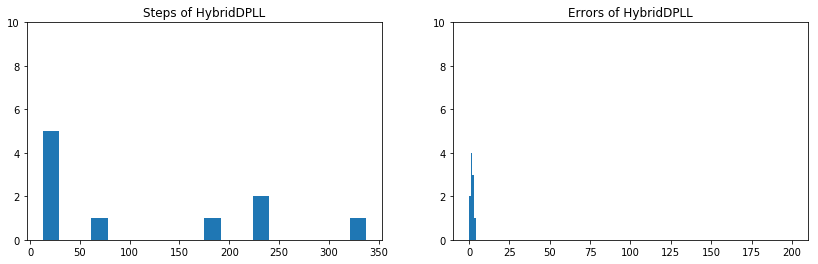

100%|██████████| 10/10 [00:28<00:00,  3.32s/it]


#Sats: 10; avg step: 134.60; stdev step: 154.45; avg error: 1.30; stdev error: 0.90


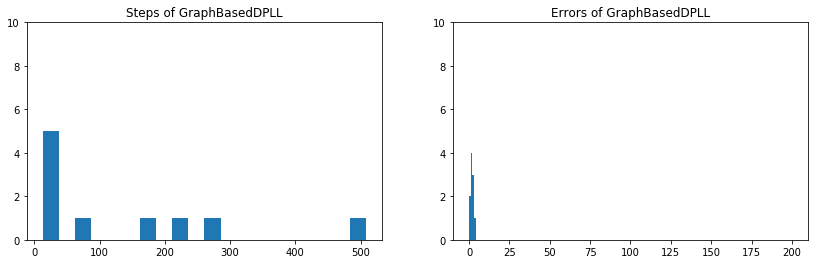

100%|██████████| 10/10 [00:00<00:00, 113.08it/s]


#Sats: 10; avg step: 43.20; stdev step: 36.79; avg error: 0.90; stdev error: 0.70


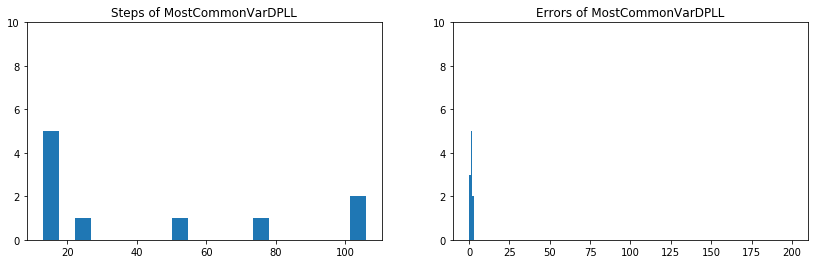

In [26]:
print_all(10, 200, 12)

 40%|████      | 4/10 [00:00<00:00, 28.16it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 20.61it/s]


#Sats: 10; avg step: 576.00; stdev step: 420.88; avg error: 7.20; stdev error: 1.72


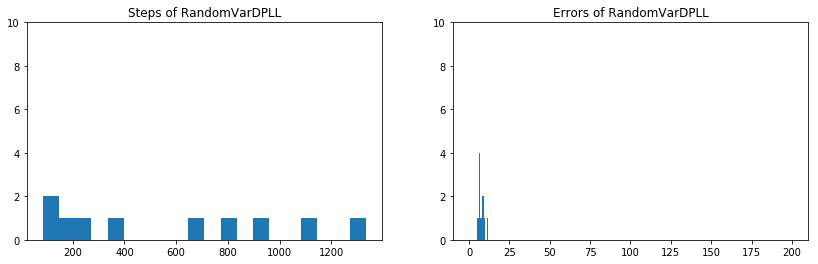

100%|██████████| 10/10 [00:00<00:00, 11.86it/s]


#Sats: 10; avg step: 440.90; stdev step: 268.11; avg error: 4.70; stdev error: 1.42


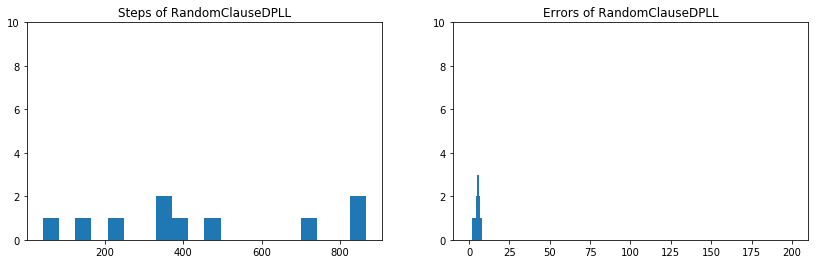

100%|██████████| 10/10 [00:26<00:00,  2.77s/it]


#Sats: 10; avg step: 286.30; stdev step: 147.23; avg error: 2.10; stdev error: 1.14


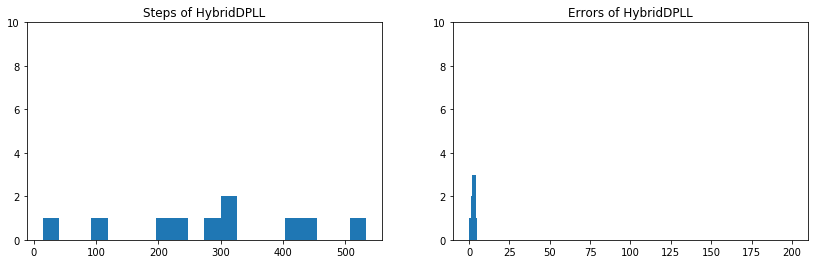

100%|██████████| 10/10 [01:18<00:00,  9.16s/it]


#Sats: 10; avg step: 467.50; stdev step: 359.26; avg error: 2.10; stdev error: 1.04


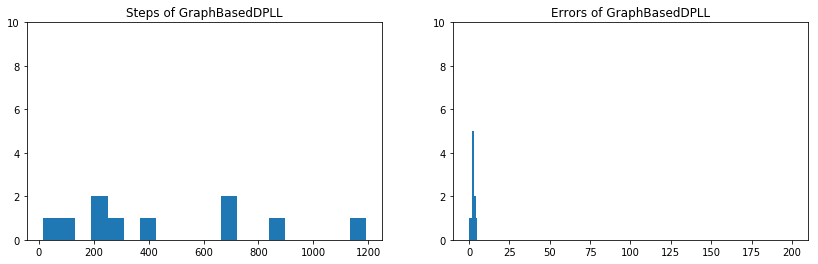

100%|██████████| 10/10 [00:00<00:00, 45.35it/s]


#Sats: 10; avg step: 200.20; stdev step: 169.31; avg error: 1.80; stdev error: 0.75


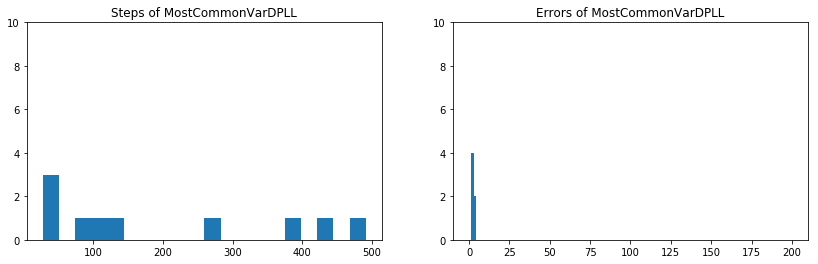

In [27]:
print_all(10, 200, 14)

 20%|██        | 2/10 [00:00<00:00, 15.38it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


#Sats: 10; avg step: 1391.90; stdev step: 932.65; avg error: 8.10; stdev error: 1.87


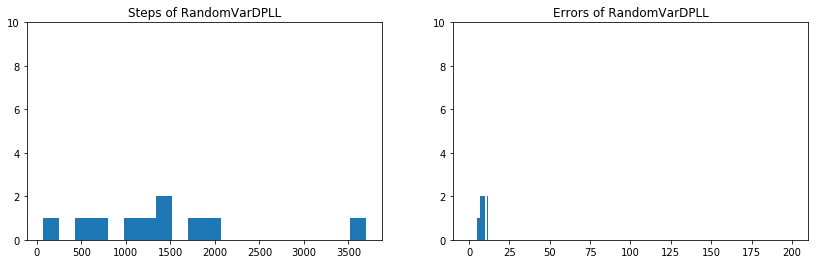

100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


#Sats: 10; avg step: 728.00; stdev step: 546.58; avg error: 4.20; stdev error: 1.40


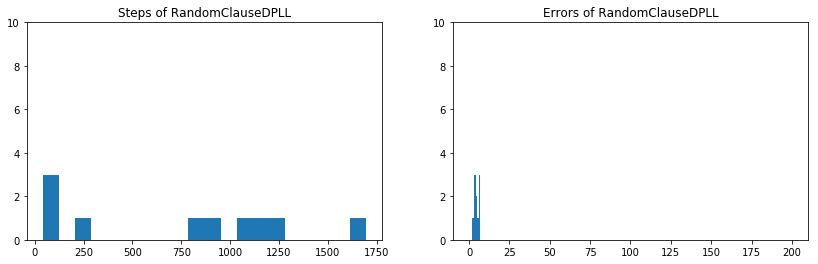

100%|██████████| 10/10 [00:21<00:00,  2.34s/it]


#Sats: 10; avg step: 560.10; stdev step: 410.95; avg error: 2.40; stdev error: 1.43


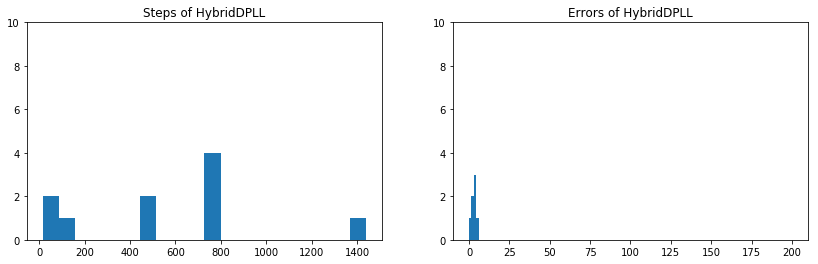

100%|██████████| 10/10 [02:28<00:00, 17.19s/it]


#Sats: 10; avg step: 1204.50; stdev step: 979.46; avg error: 2.20; stdev error: 1.08


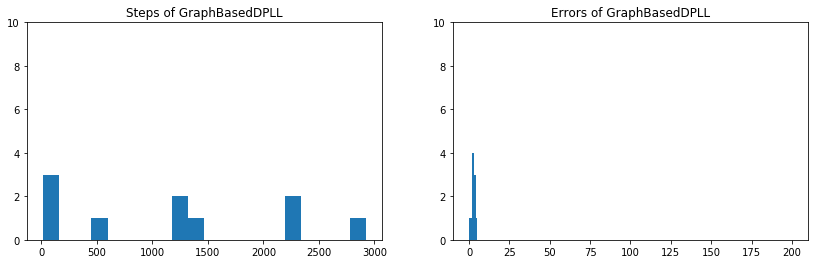

100%|██████████| 10/10 [00:00<00:00, 19.34it/s]


#Sats: 10; avg step: 506.70; stdev step: 182.15; avg error: 3.00; stdev error: 0.77


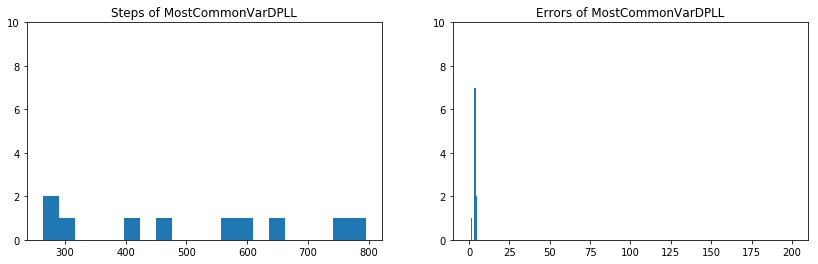

In [ ]:
print_all(10, 200, 16)

 20%|██        | 2/10 [00:00<00:00, 14.01it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


#Sats: 10; avg step: 1213.40; stdev step: 525.15; avg error: 8.60; stdev error: 2.33


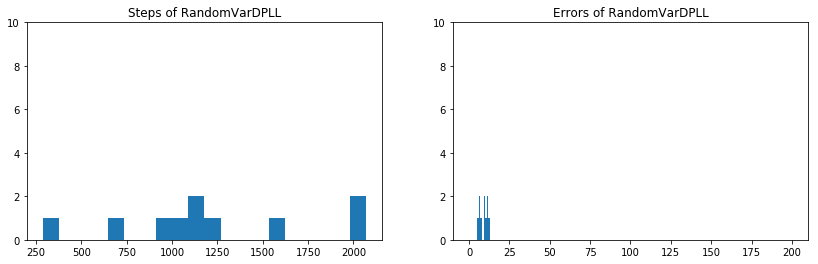

100%|██████████| 10/10 [00:00<00:00, 11.78it/s]


#Sats: 10; avg step: 1091.50; stdev step: 759.95; avg error: 5.00; stdev error: 1.90


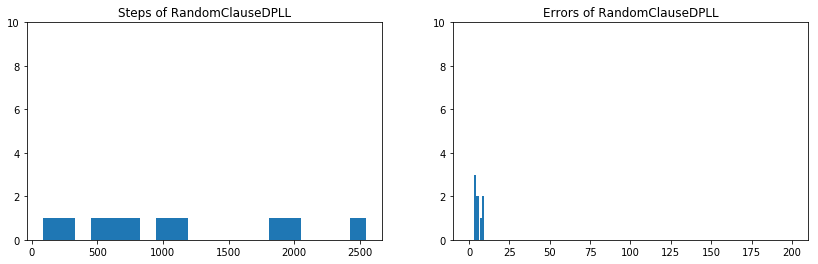

100%|██████████| 10/10 [00:24<00:00,  1.93s/it]


#Sats: 10; avg step: 533.10; stdev step: 556.15; avg error: 2.30; stdev error: 1.19


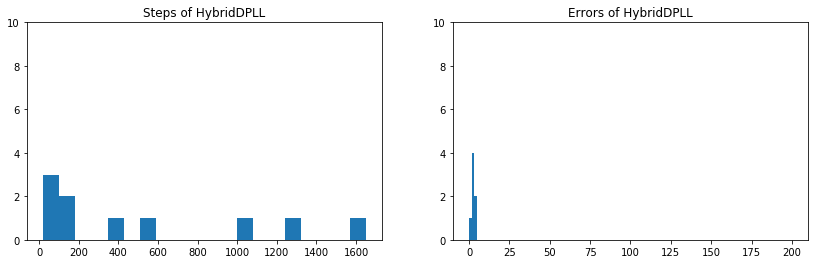

100%|██████████| 10/10 [04:29<00:00, 14.66s/it]


#Sats: 10; avg step: 2014.30; stdev step: 2755.62; avg error: 2.10; stdev error: 0.94


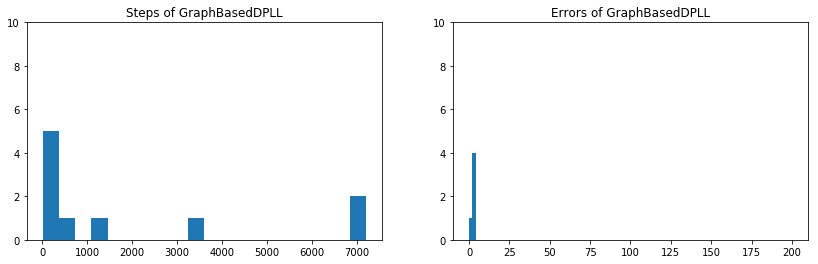

100%|██████████| 10/10 [00:00<00:00, 25.10it/s]


#Sats: 10; avg step: 354.90; stdev step: 305.13; avg error: 2.50; stdev error: 1.02


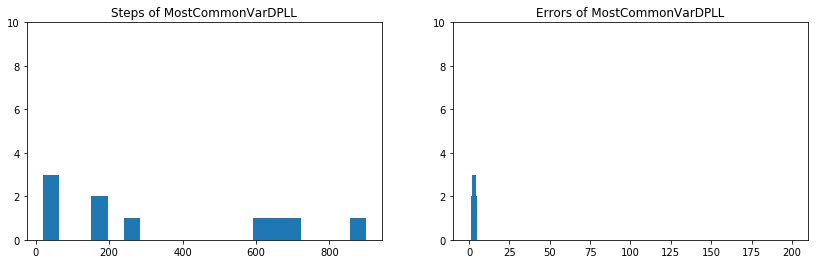

In [ ]:
print_all(10, 200, 18)

 10%|█         | 1/10 [00:00<00:01,  7.07it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:03<00:00,  2.38it/s]


#Sats: 10; avg step: 4930.70; stdev step: 2502.46; avg error: 9.70; stdev error: 1.85


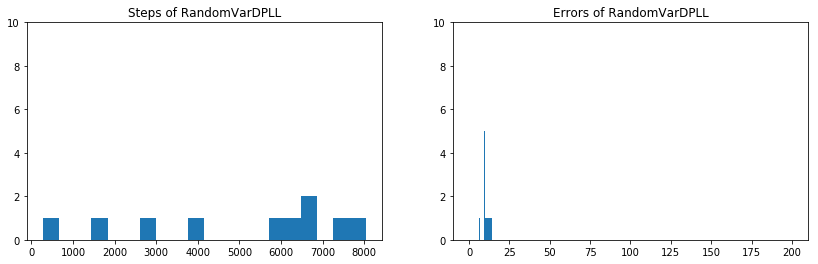

100%|██████████| 10/10 [00:02<00:00,  2.59it/s]


#Sats: 10; avg step: 3143.70; stdev step: 2341.79; avg error: 5.90; stdev error: 1.87


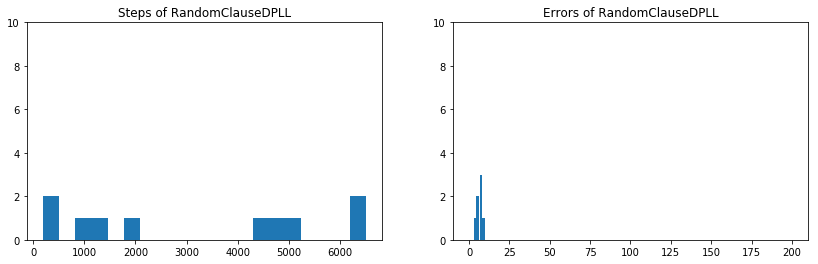

100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


#Sats: 10; avg step: 1371.90; stdev step: 886.10; avg error: 3.50; stdev error: 1.57


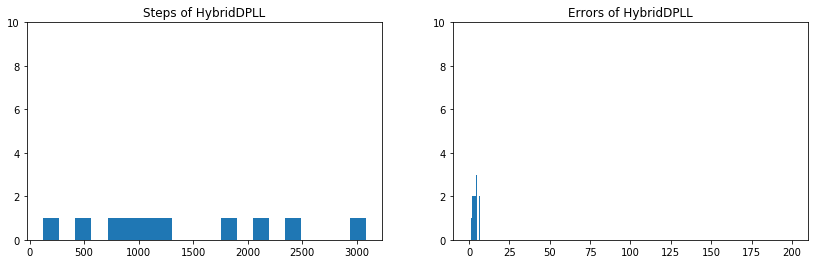

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print_all(10, 200, 20)

In [ ]:
print_all(10, 500, 25)

In [ ]:
print_all(10, 500, 30, light=True)

In [ ]:
print_all(10, 500, 40, light=True)

In [ ]:
print_all(10, 500, 50, light=True)